In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xclimate as xclim

In [2]:
%load_ext autoreload
%autoreload 2

%aimport xclimate

In [3]:
dpi = 100

In [20]:
variables = [
    "EFLX_LH_TOT_month_1",
    "EFLX_LH_TOT_year_1",
    "PRECT_day_1",
    "PRECT_month_1",
    "TOTANNPRECT_year_1",
    "PRDIFF_year_1",
    "TLAI_month_1",
    "TLAI_year_1",
    "TSA_day_1",
    "TSA_month_1",
    "TSA_year_1",   
    "WDFRQ_year_1",
]

rootdir = Path("/glade/work/bbuchovecky/et_controls/proc/quantiles")
qs = {}
for v in variables:
    qs[v] = xr.open_dataset(rootdir / f"quantiles.1995-2014.TIMEagg.{v}.nc", decode_timedelta=False)

Text(0.5, 0.98, 'EFLX_LH_TOT_month_1 $-$ 50 quantiles')

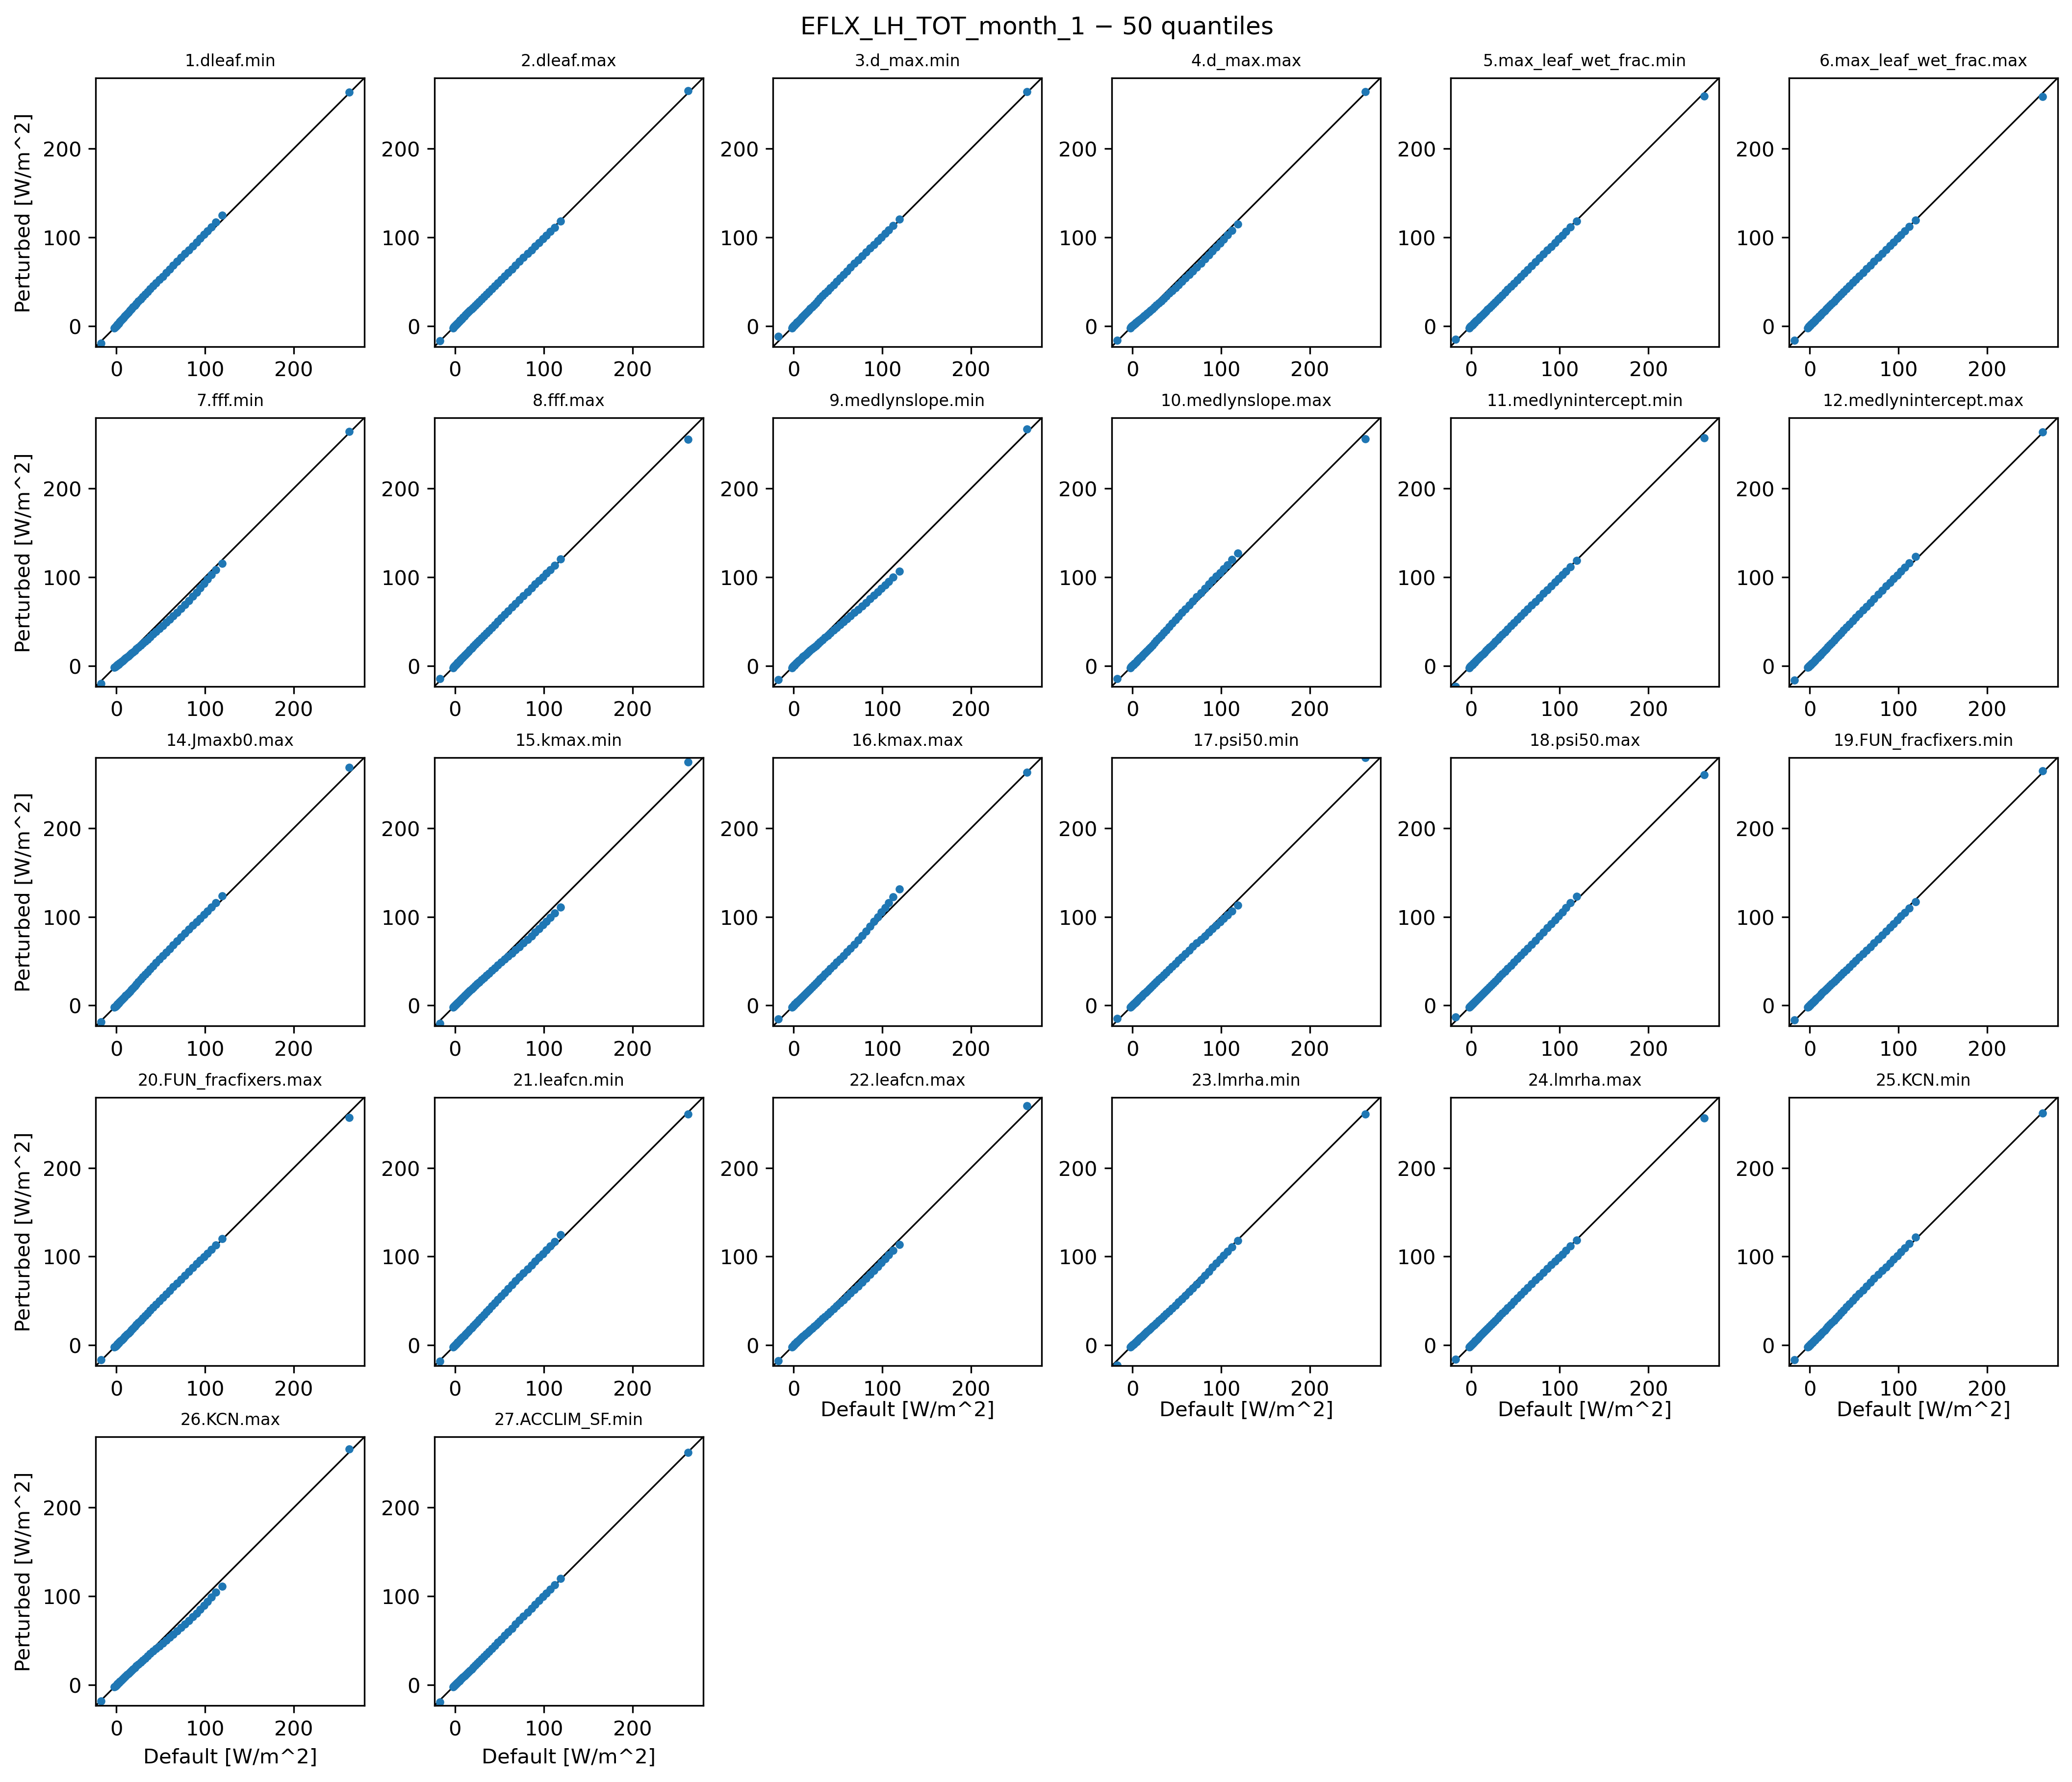

In [39]:
v = "EFLX_LH_TOT_month_1"
nb = 50
# ticks = np.arange(0, 16, 5)

q = qs[v][f"qbin_{nb}"]

ncols = 6
nrows = 5
fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows,
    sharex=False, sharey=False,
    figsize=(14, 12),
    subplot_kw=dict(box_aspect=1),
    constrained_layout=True,
    dpi=300,
)
ax = axs.flatten()

low = q.min()
hgh = q.max()

for i, m in enumerate(q.member.sel(member=slice(1, None))):
    ax[i].plot(
        q.sel(member=0),
        q.sel(member=m),
        color="tab:blue",
        lw=0,
        marker=".",
    )
    ax[i].set_title(xclim.ppe.get_member_name(m), fontsize=8)
    ax[i].set_aspect("equal")
    
    ax[i].plot([low, hgh], [low, hgh], color="k", lw=0.8, zorder=0)
    ax[i].set_xlim(low, hgh)
    ax[i].set_ylim(low, hgh)

    # ax[i].set_yticks(ticks)
    # ax[i].set_xticks(ticks)
    if i % ncols == 0:
        ax[i].set_ylabel(f"Perturbed [{q.units}]", fontsize=10)
    if i // ncols == nrows - 1:
        ax[i].set_xlabel(f"Default [{q.units}]", fontsize=10)

for i in range(len(q.member) - 1, ncols * nrows):
    ax[i].remove()

xclim.plot.add_orphan_xlabel(
    fig,
    ax,
    len(q.member.sel(member=slice(1, None))),
    ncols,
    nrows,
    f"Default [{q.units}]",
    fontsize=10
)

fig.suptitle(f"{v} $-$ {nb} quantiles")

---

In [29]:
nonglc_pct_threshold = 80
grid = xclim.load_fhist_ppe_grid()
nonglc_mask = grid.PCT_GLC < nonglc_pct_threshold

time_slice = slice("1995-01", "2014-12")
time_start = time_slice.start
time_stop = time_slice.stop

In [30]:
variables = [
    "PRECC_month_1",
    "PRECL_month_1",
    "TLAI_month_1",
    "EFLX_LH_TOT_month_1",
    # "PRECT_day_1",
    # "TSA_day_1",
]
time_slice = slice("1995-01", "2014-12")

fhist = {}
for v in variables:
    print(v)
    name = "_".join(v.split("_")[:-2])
    fhist[v] = xclim.load_fhist(v, keep_var_only=True)[name].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)

PRECC_month_1
PRECL_month_1
TLAI_month_1
EFLX_LH_TOT_month_1


In [31]:
# Monthly precipitation rate (PRECC + PRECL)
fhist["PRECT_month_1"] = fhist["PRECC_month_1"] + fhist["PRECL_month_1"]

# Annual mean TLAI
fhist["TLAI_year_1"] = fhist["TLAI_month_1"].groupby("time.year").map(lambda x: x.weighted(x.time.dt.days_in_month).mean("time"))

# Annual mean ET
fhist["EFLX_LH_TOT_year_1"] = fhist["EFLX_LH_TOT_month_1"].groupby("time.year").map(lambda x: x.weighted(x.time.dt.days_in_month).mean("time"))

# Wet-day frequency as defined in Feldman et al. (2024) - the annual number of days with above 1 mm/day of precipitation
# DAILY_PRECT_THRESH =  1 / (1000 * 24 * 60 * 60)  # [m/s] = 1 [mm/day]
# fhist["WDFRQ_year_1"] = (fhist["PRECT_day_1"].where(grid>0) > DAILY_PRECT_THRESH).groupby("time.year").sum()

# Annual difference between highest and lowest precipitation months
fhist["PRDIFF_year_1"] = fhist["PRECT_month_1"].groupby("time.year").map(lambda x: x.max(dim="time") - x.min(dim="time"))

In [21]:
quantile_variables = ["TLAI_month_1", "EFLX_LH_TOT_month_1"]
n_qbin = np.array([15, 25, 50, 75, 100])

qs_ds = {}
qs = {}
for qv in quantile_variables:
    print(qv)
    qs_list = []
    qs[qv] = {}
    for nb in n_qbin:
        x = fhist[qv].where(nonglc_mask)
        x_s = x.stack(gridcell=["lat", "lon", "time"])
        qs[qv][str(nb)] = xclim.get_quantiles(x_s, nb, ["gridcell"]).rename(f"qbin_{nb}", quantile=f"qb{nb}").assign_attrs(description=f"{nb} quantiles of {v}")
        qs_list.append(qs[qv][str(nb)])
    qs_ds[qv] = xr.merge(qs_list)

TLAI_month_1
EFLX_LH_TOT_month_1


In [22]:
qs_ds["EFLX_LH_TOT_month_1"]

<xarray.Dataset> Size: 61kB
Dimensions:   (member: 27, qb15: 16, qb25: 26, qb50: 51, qb75: 76, qb100: 101)
Coordinates:
  * member    (member) int64 216B 0 1 2 3 4 5 6 7 8 ... 20 21 22 23 24 25 26 27
  * qb15      (qb15) float64 128B 0.0 0.06667 0.1333 0.2 ... 0.8667 0.9333 1.0
  * qb25      (qb25) float64 208B 0.0 0.04 0.08 0.12 0.16 ... 0.88 0.92 0.96 1.0
  * qb50      (qb50) float64 408B 0.0 0.02 0.04 0.06 0.08 ... 0.94 0.96 0.98 1.0
  * qb75      (qb75) float64 608B 0.0 0.01333 0.02667 0.04 ... 0.9733 0.9867 1.0
  * qb100     (qb100) float64 808B 0.0 0.01 0.02 0.03 ... 0.97 0.98 0.99 1.0
Data variables:
    qbin_15   (qb15, member) float64 3kB dask.array<chunksize=(16, 10), meta=np.ndarray>
    qbin_25   (qb25, member) float64 6kB dask.array<chunksize=(26, 10), meta=np.ndarray>
    qbin_50   (qb50, member) float64 11kB dask.array<chunksize=(51, 10), meta=np.ndarray>
    qbin_75   (qb75, member) float64 16kB dask.array<chunksize=(76, 10), meta=np.ndarray>
    qbin_100  (qb100, member) float64 22kB dask.array<chunksize=(101, 10), meta=np.ndarray>
Attributes:
    long_name:     total latent heat flux [+ to atm]
    units:         W/m^2
    cell_methods:  time: mean
    description:   15 quantiles of EFLX_LH_TOT_month_1

In [52]:
v = "TLAI_month_1"
units = "m$^2$/m$^2$"
nb = 25

x = fhist[v].where(nonglc_mask)
x_s = x.stack(gridcell=["lat", "lon", "time"])
x_qedge = xclim.get_quantiles(x_s, nb, ["gridcell"])

x_s_np = x_s.sel(member=0).values
x_s_np = x_s_np[~np.isnan(x_s_np)]
_, def_bins = np.histogram(x_s_np, bins=nb)

/glade/derecho/scratch/bbuchovecky/tmp/ipykernel_33573/3700132823.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(a.get_yticks() / 1e3)
/glade/derecho/scratch/bbuchovecky/tmp/ipykernel_33573/3700132823.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(a.get_yticks() / 1e3)


Text(0.5, 0.98, 'TLAI_month_1 $-$ 0.default.default $-$ 1995-01 to 2014-12\ngridcell = stack(lat, lon, month)')

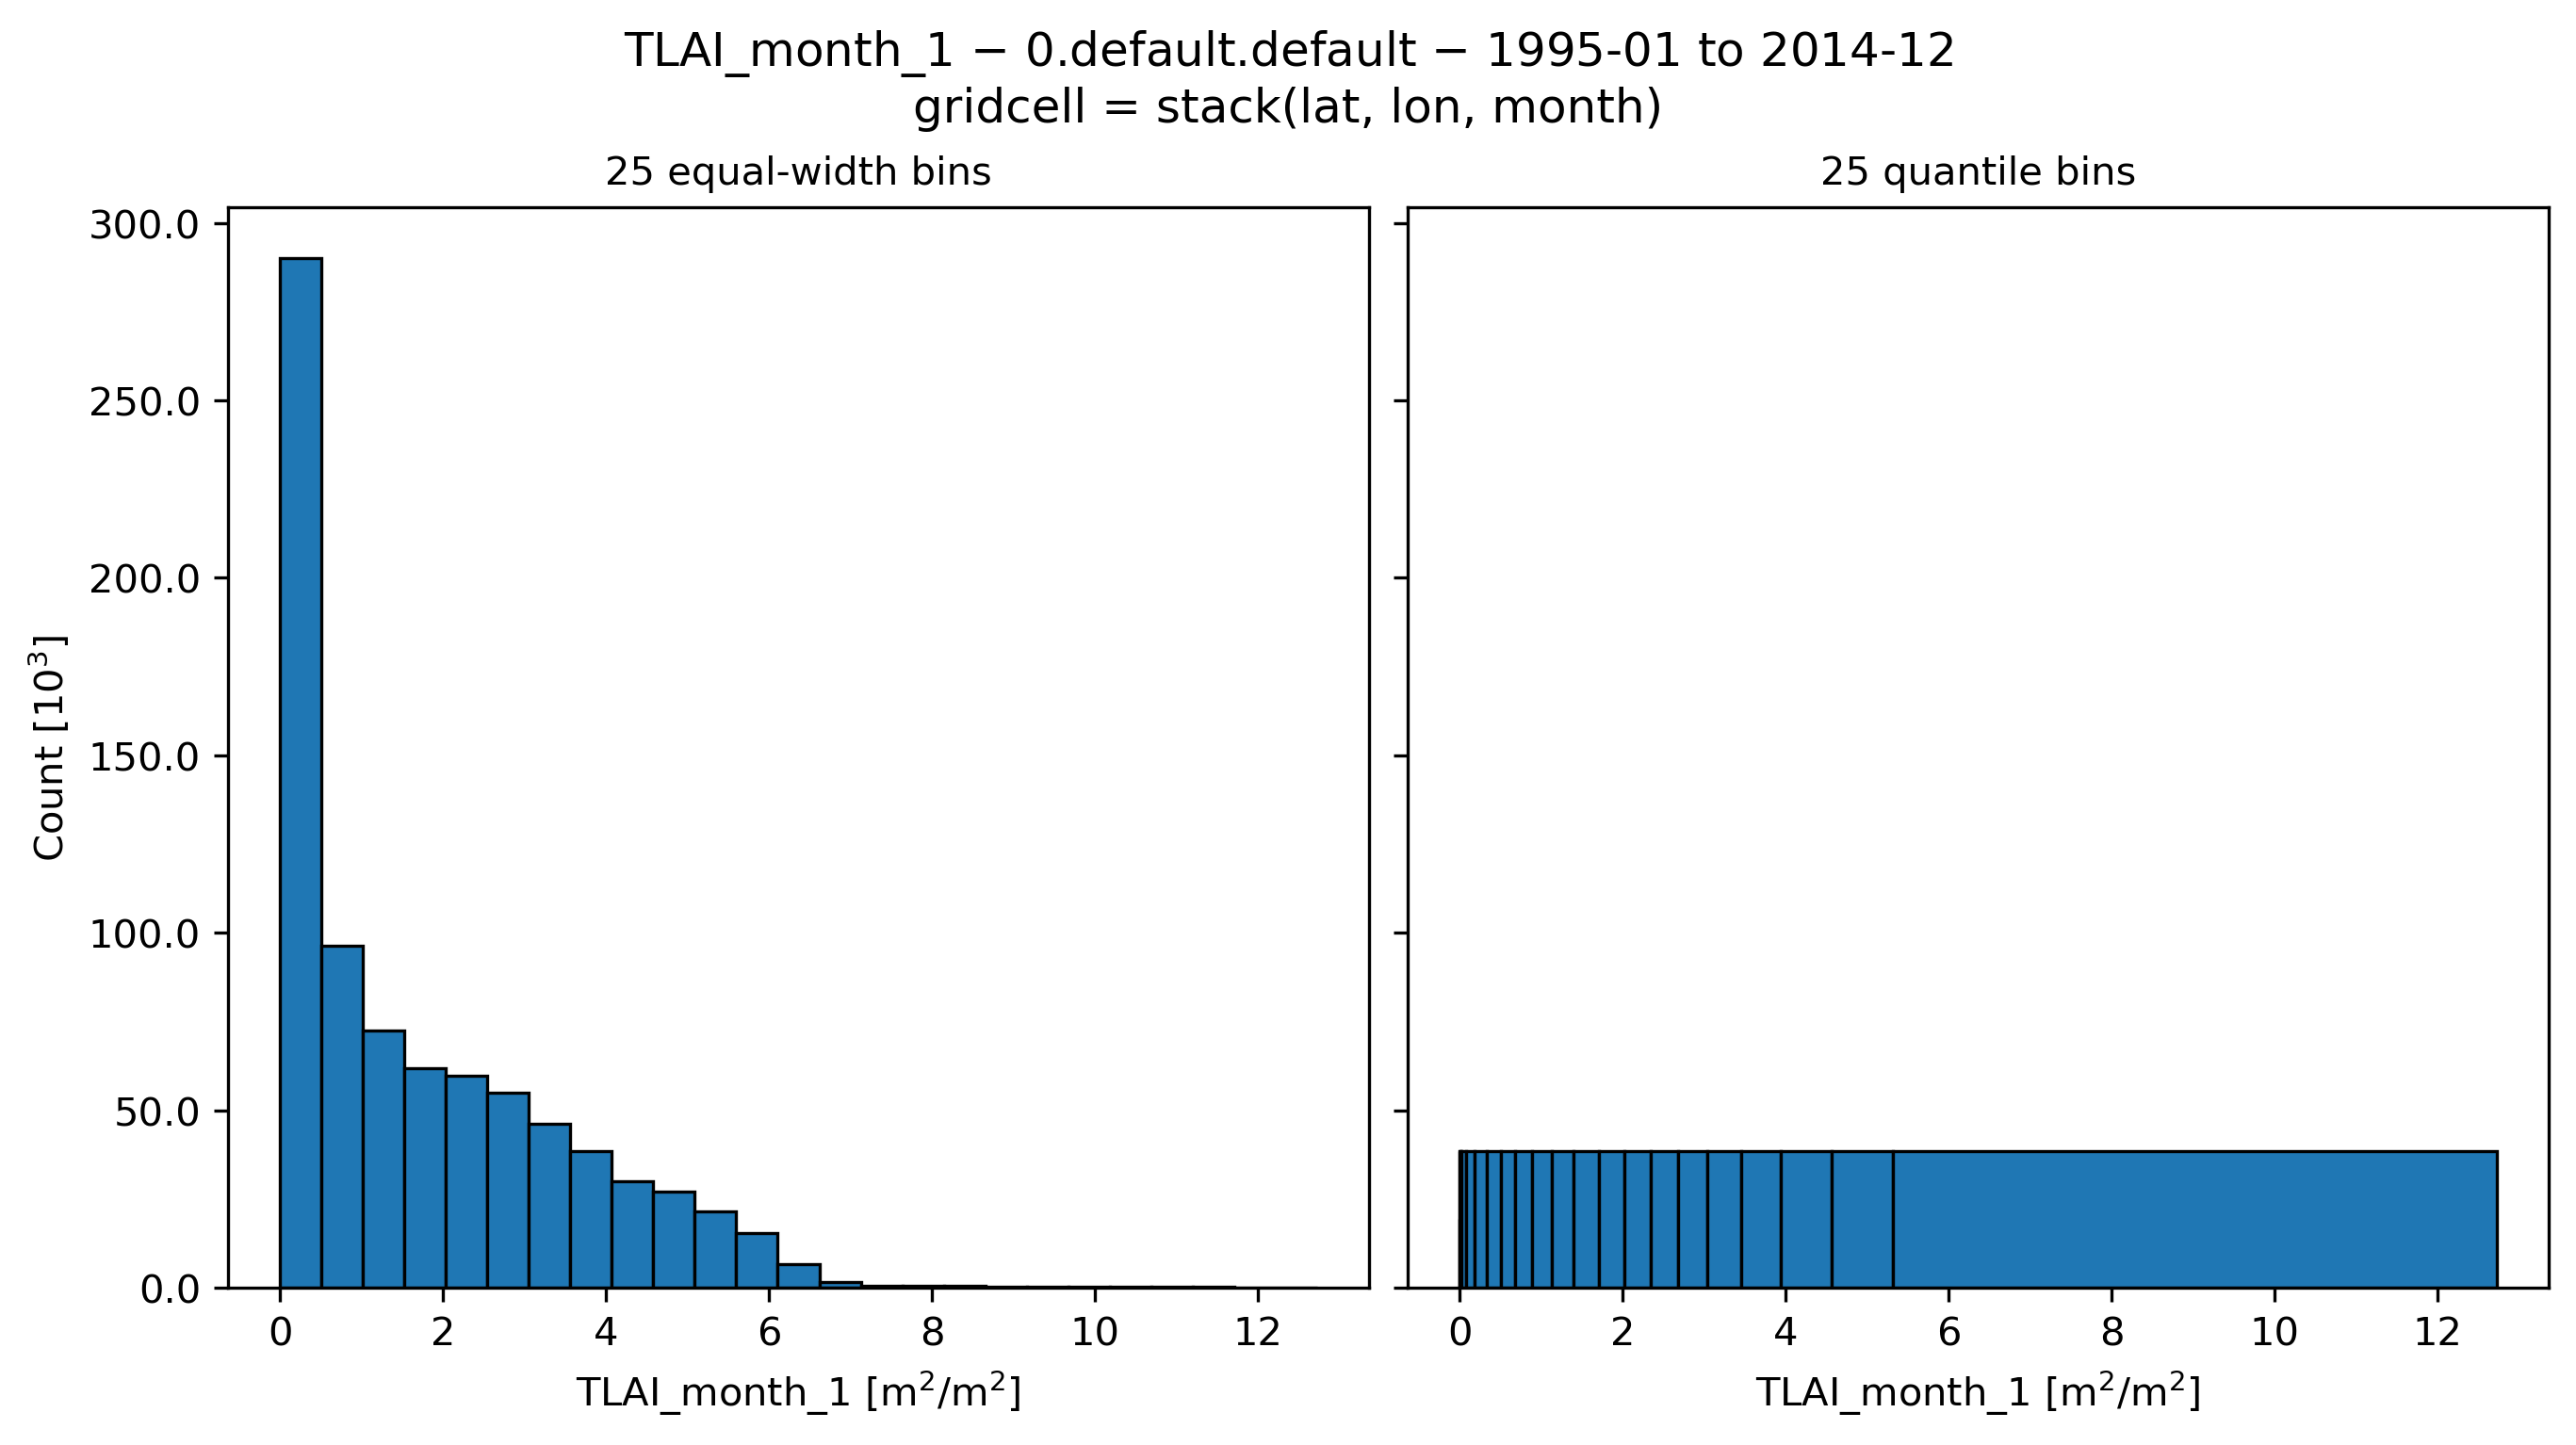

In [ ]:
m = 0

fig, ax = plt.subplots(1, 2, figsize=(9, 5), sharey=True, sharex=True, layout="constrained", dpi=300)
x_s.sel(member=m).where(x_s.sel(member=m) > 0).plot.hist(ax=ax[0], bins=nb, edgecolor="k", linewidth=0.8)
x_s.sel(member=m).where(x_s.sel(member=m) > 0).plot.hist(ax=ax[1], bins=x_qedge.sel(member=m), edgecolor="k", linewidth=0.8)
for a in ax:
    a.set_yticklabels(a.get_yticks() / 1e3)
    a.set_xlabel(f"{v} [{units}]")
ax[0].set_ylabel("Count [10$^3$]")
ax[0].set_title(f"{nb} equal-width bins", fontsize=10)
ax[1].set_title(f"{nb} quantile bins", fontsize=10)
fig.suptitle(f"{v} $-$ {xclim.ppe.get_member_name(m)} $-$ {time_start} to {time_stop}\ngridcell = stack(lat, lon, month)")

/glade/derecho/scratch/bbuchovecky/tmp/ipykernel_33573/2766063124.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(a.get_yticks() / 1e3)
/glade/derecho/scratch/bbuchovecky/tmp/ipykernel_33573/2766063124.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(a.get_yticks() / 1e3)


Text(0.5, 0.98, 'TLAI_month_1 $-$ 23.lmrha.min $-$ 1995-01 to 2014-12\ngridcell = stack(lat, lon, month)')

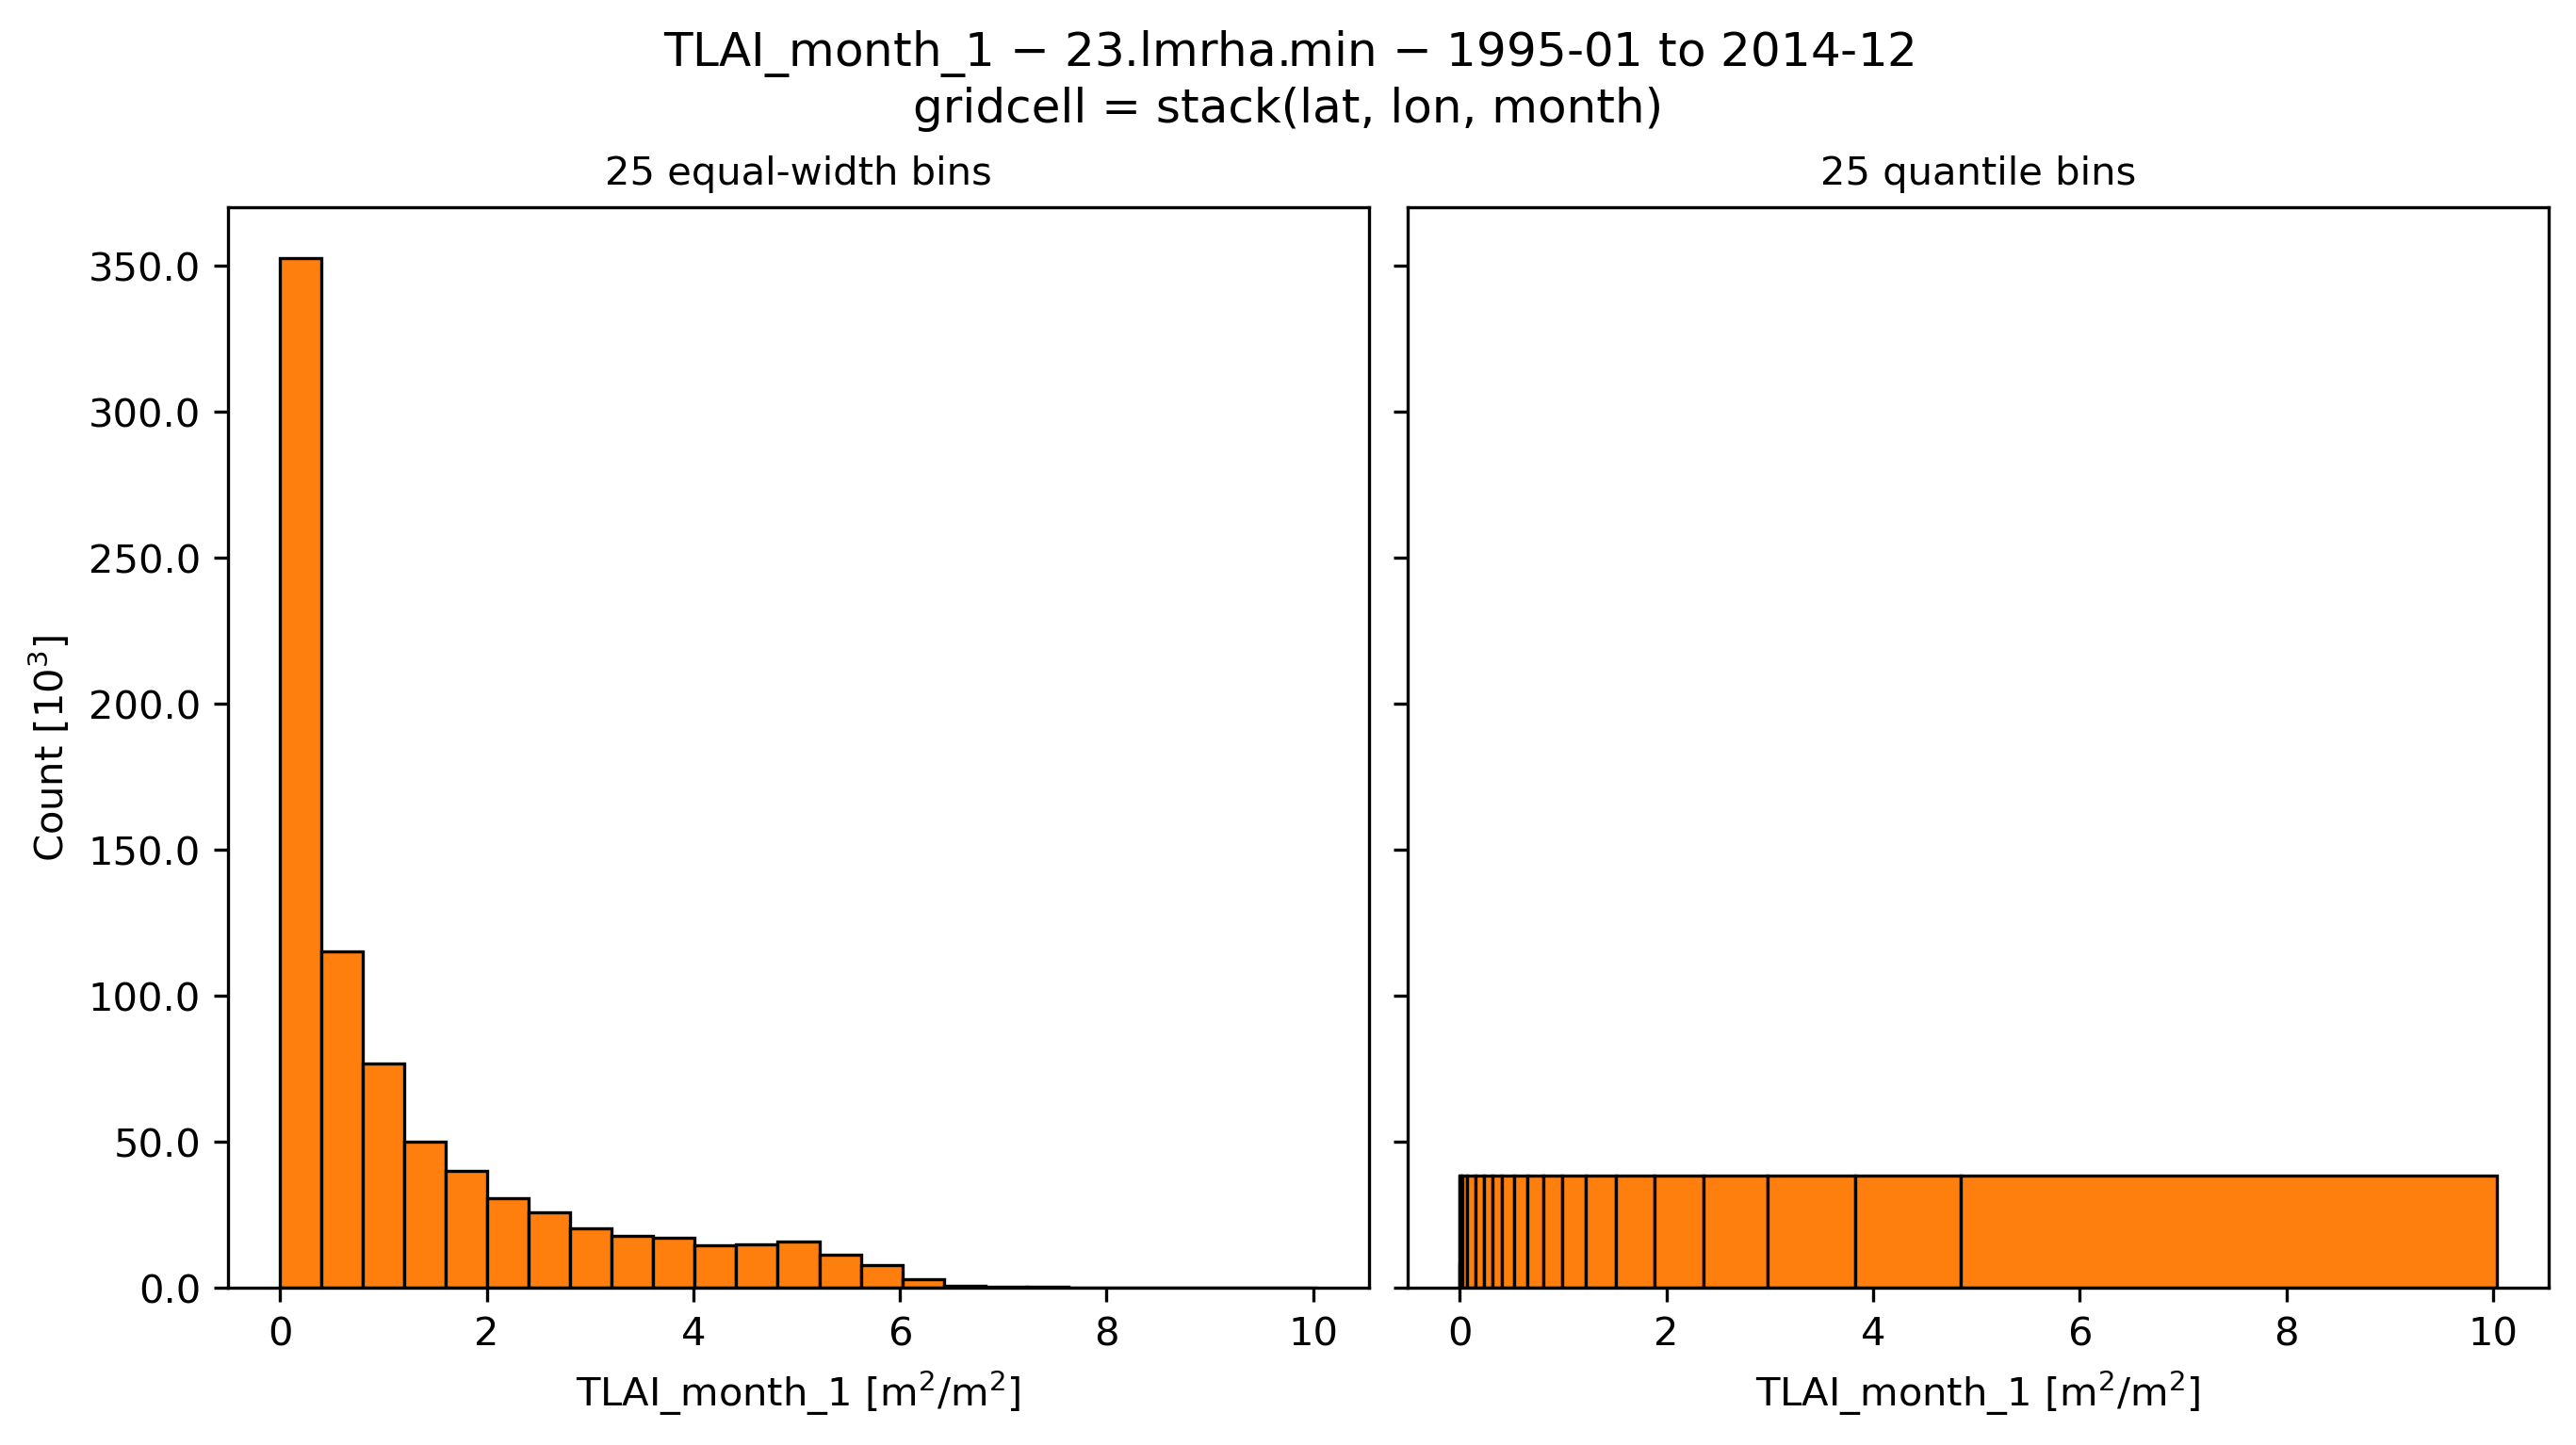

In [39]:
m = 23

fig, ax = plt.subplots(1, 2, figsize=(9, 5), sharey=True, sharex=True, layout="constrained", dpi=300)
x_s.sel(member=m).where(x_s.sel(member=m) > 0).plot.hist(ax=ax[0], bins=nb, facecolor="tab:orange", edgecolor="k", linewidth=0.8)
x_s.sel(member=m).where(x_s.sel(member=m) > 0).plot.hist(ax=ax[1], bins=x_qedge.sel(member=m), facecolor="tab:orange", edgecolor="k", linewidth=0.8)
for a in ax:
    a.set_yticklabels(a.get_yticks() / 1e3)
    a.set_xlabel(f"{v} [{units}]")
ax[0].set_ylabel("Count [10$^3$]")
ax[0].set_title(f"{nb} equal-width bins", fontsize=10)
ax[1].set_title(f"{nb} quantile bins", fontsize=10)
fig.suptitle(f"{v} $-$ {xclim.ppe.get_member_name(m)} $-$ {time_start} to {time_stop}\ngridcell = stack(lat, lon, month)")

/glade/derecho/scratch/bbuchovecky/tmp/ipykernel_33573/1155342523.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(a.get_yticks() / 1e3)
/glade/derecho/scratch/bbuchovecky/tmp/ipykernel_33573/1155342523.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(a.get_yticks() / 1e3)


Text(0.5, 0.98, 'TLAI_month_1 $-$ 23.lmrha.min $-$ 1995-01 to 2014-12\ngridcell = stack(lat, lon, month)')

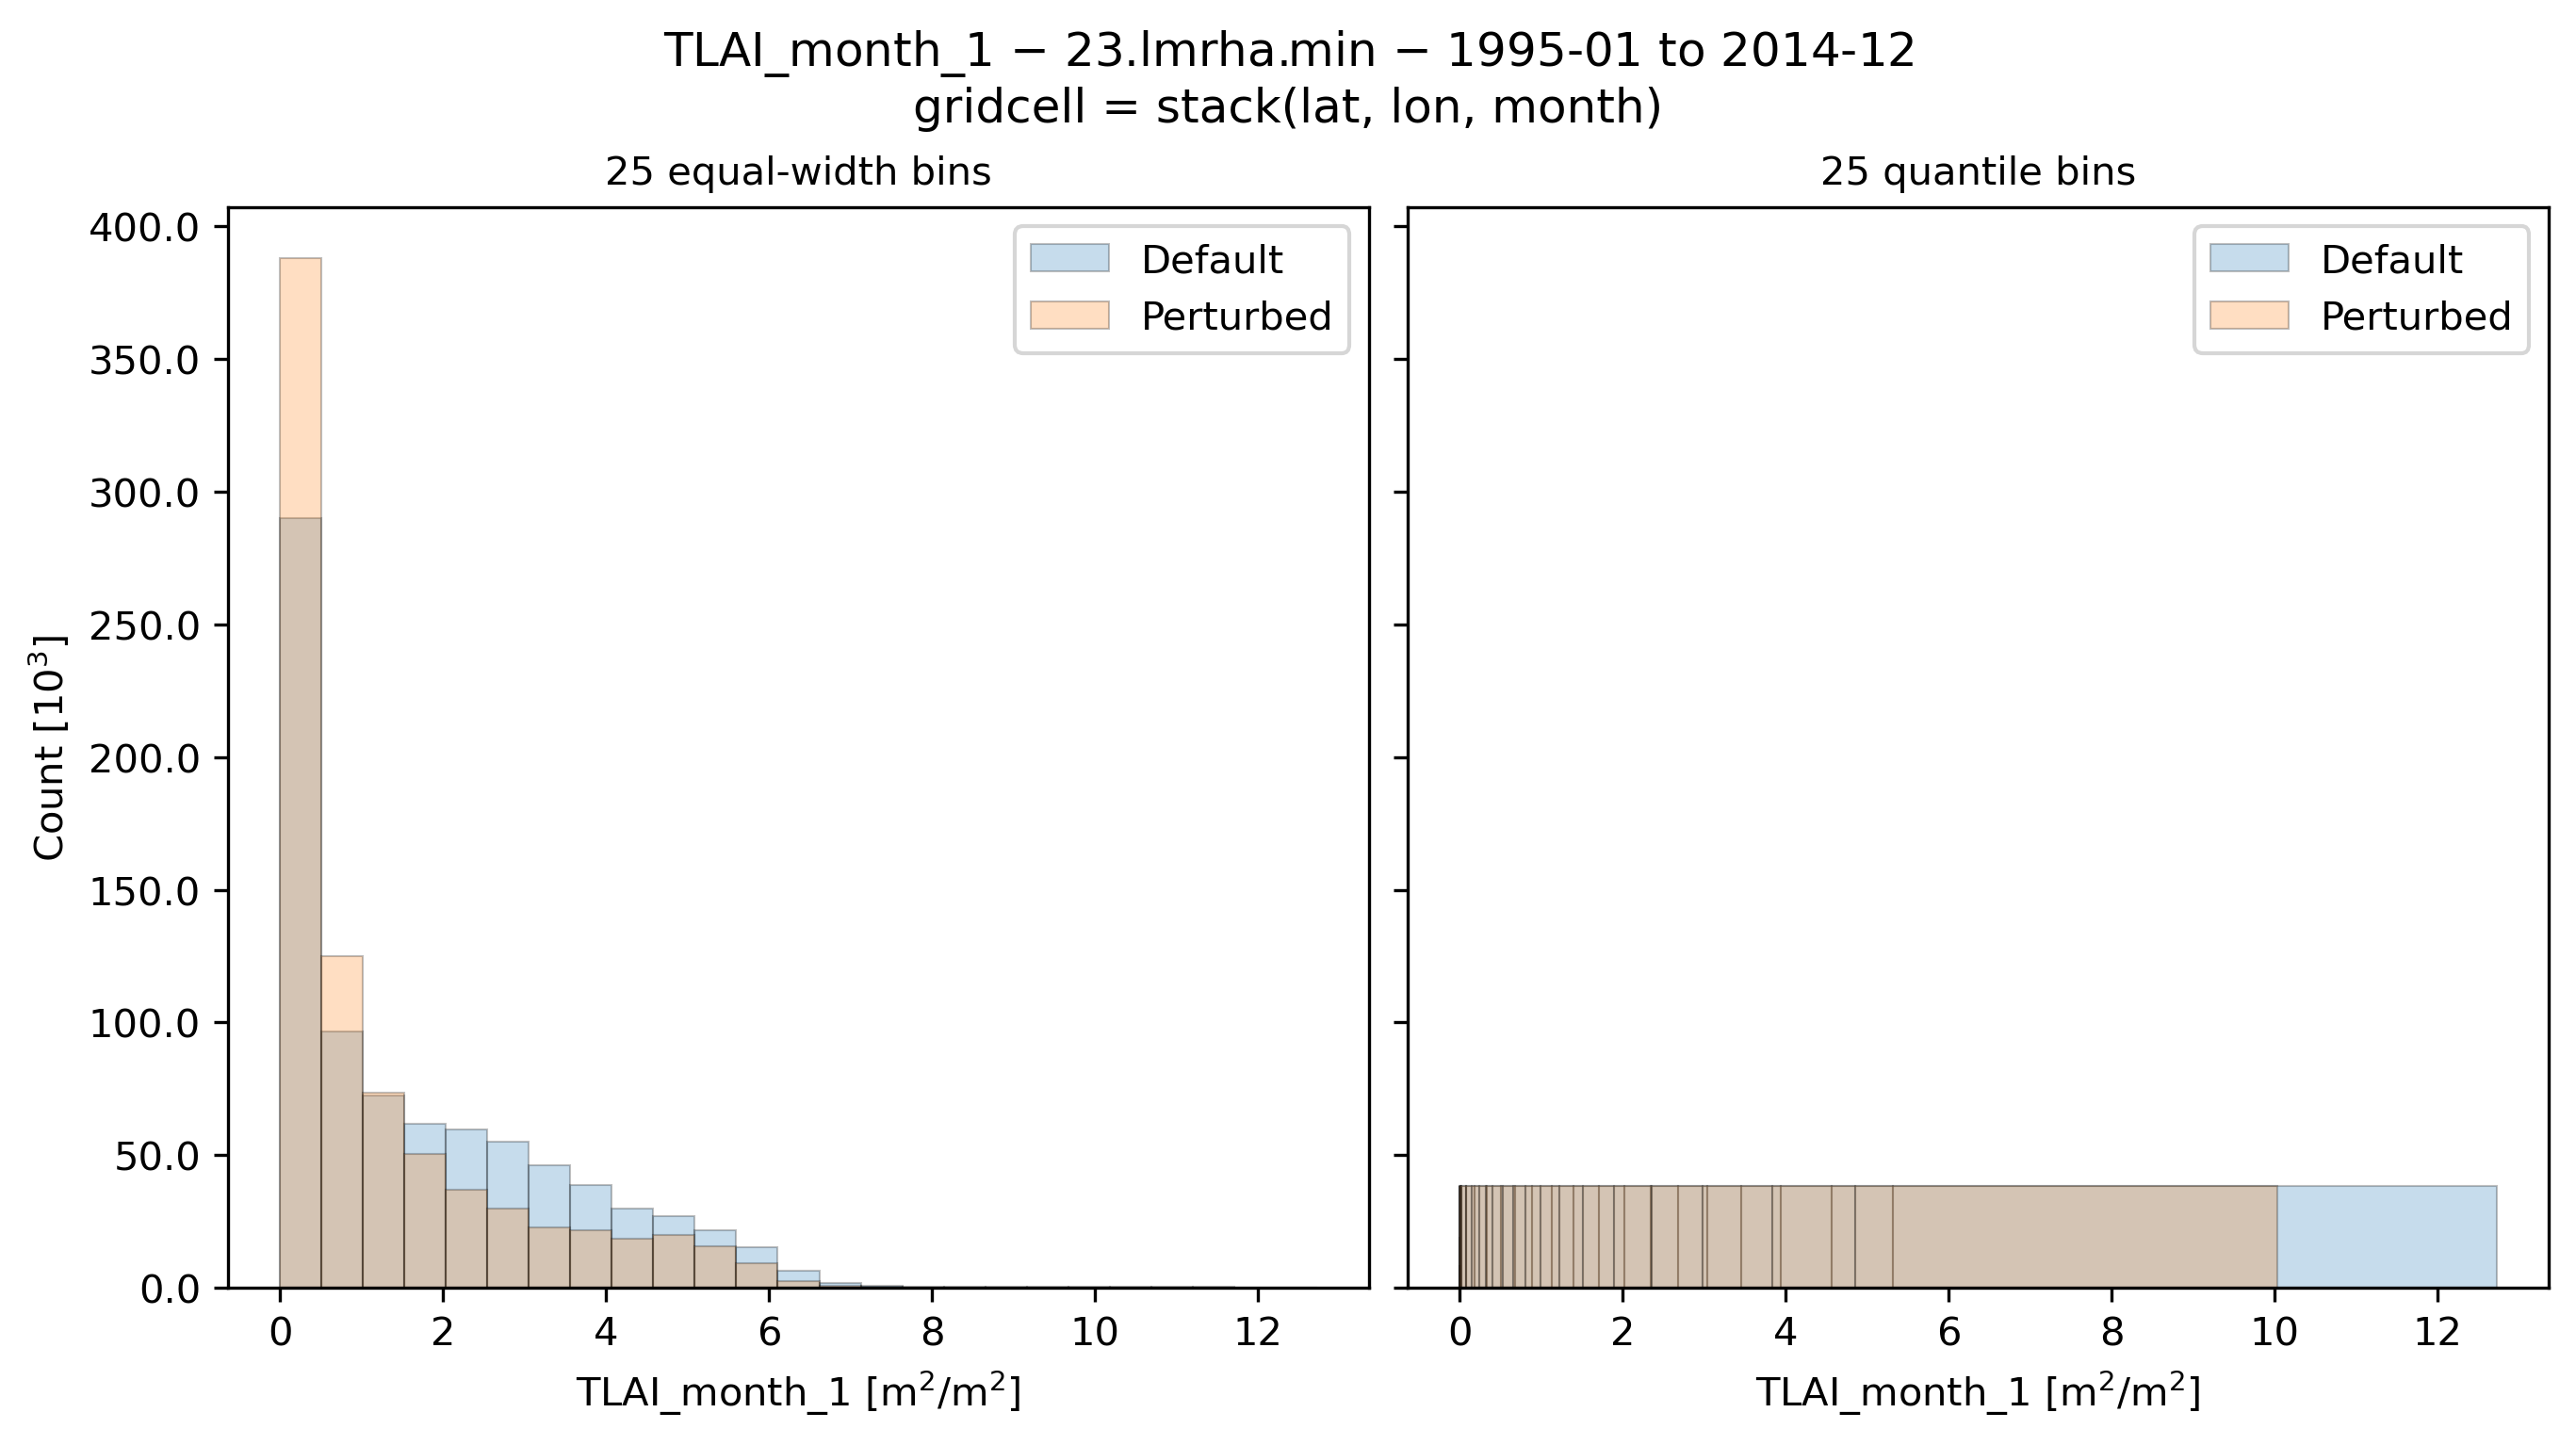

In [54]:
m = 23

fig, ax = plt.subplots(1, 2, figsize=(9, 5), sharey=True, sharex=True, layout="constrained", dpi=300)

x_s.sel(member=0).where(x_s.sel(member=0) > 0).plot.hist(ax=ax[0], bins=def_bins, facecolor="tab:blue", edgecolor="k", linewidth=0.5, alpha=0.25, label="Default")
x_s.sel(member=m).where(x_s.sel(member=m) > 0).plot.hist(ax=ax[0], bins=def_bins, facecolor="tab:orange", edgecolor="k", linewidth=0.5, alpha=0.25, label="Perturbed")

x_s.sel(member=0).where(x_s.sel(member=0) > 0).plot.hist(ax=ax[1], bins=x_qedge.sel(member=0), facecolor="tab:blue", edgecolor="k", linewidth=0.5, alpha=0.25, label="Default")
x_s.sel(member=m).where(x_s.sel(member=m) > 0).plot.hist(ax=ax[1], bins=x_qedge.sel(member=m), facecolor="tab:orange", edgecolor="k", linewidth=0.5, alpha=0.25, label="Perturbed")

for a in ax:
    a.set_yticklabels(a.get_yticks() / 1e3)
    a.set_xlabel(f"{v} [{units}]")
    a.legend(loc="upper right")
ax[0].set_ylabel("Count [10$^3$]")
ax[0].set_title(f"{nb} equal-width bins", fontsize=10)
ax[1].set_title(f"{nb} quantile bins", fontsize=10)
fig.suptitle(f"{v} $-$ {xclim.ppe.get_member_name(m)} $-$ {time_start} to {time_stop}\ngridcell = stack(lat, lon, month)")

Text(0.5, 1.0, 'TLAI_month_1 $-$ 0.default.default $-$ 1995-01 to 2014-12\ngridcell = stack(lat, lon, month)')

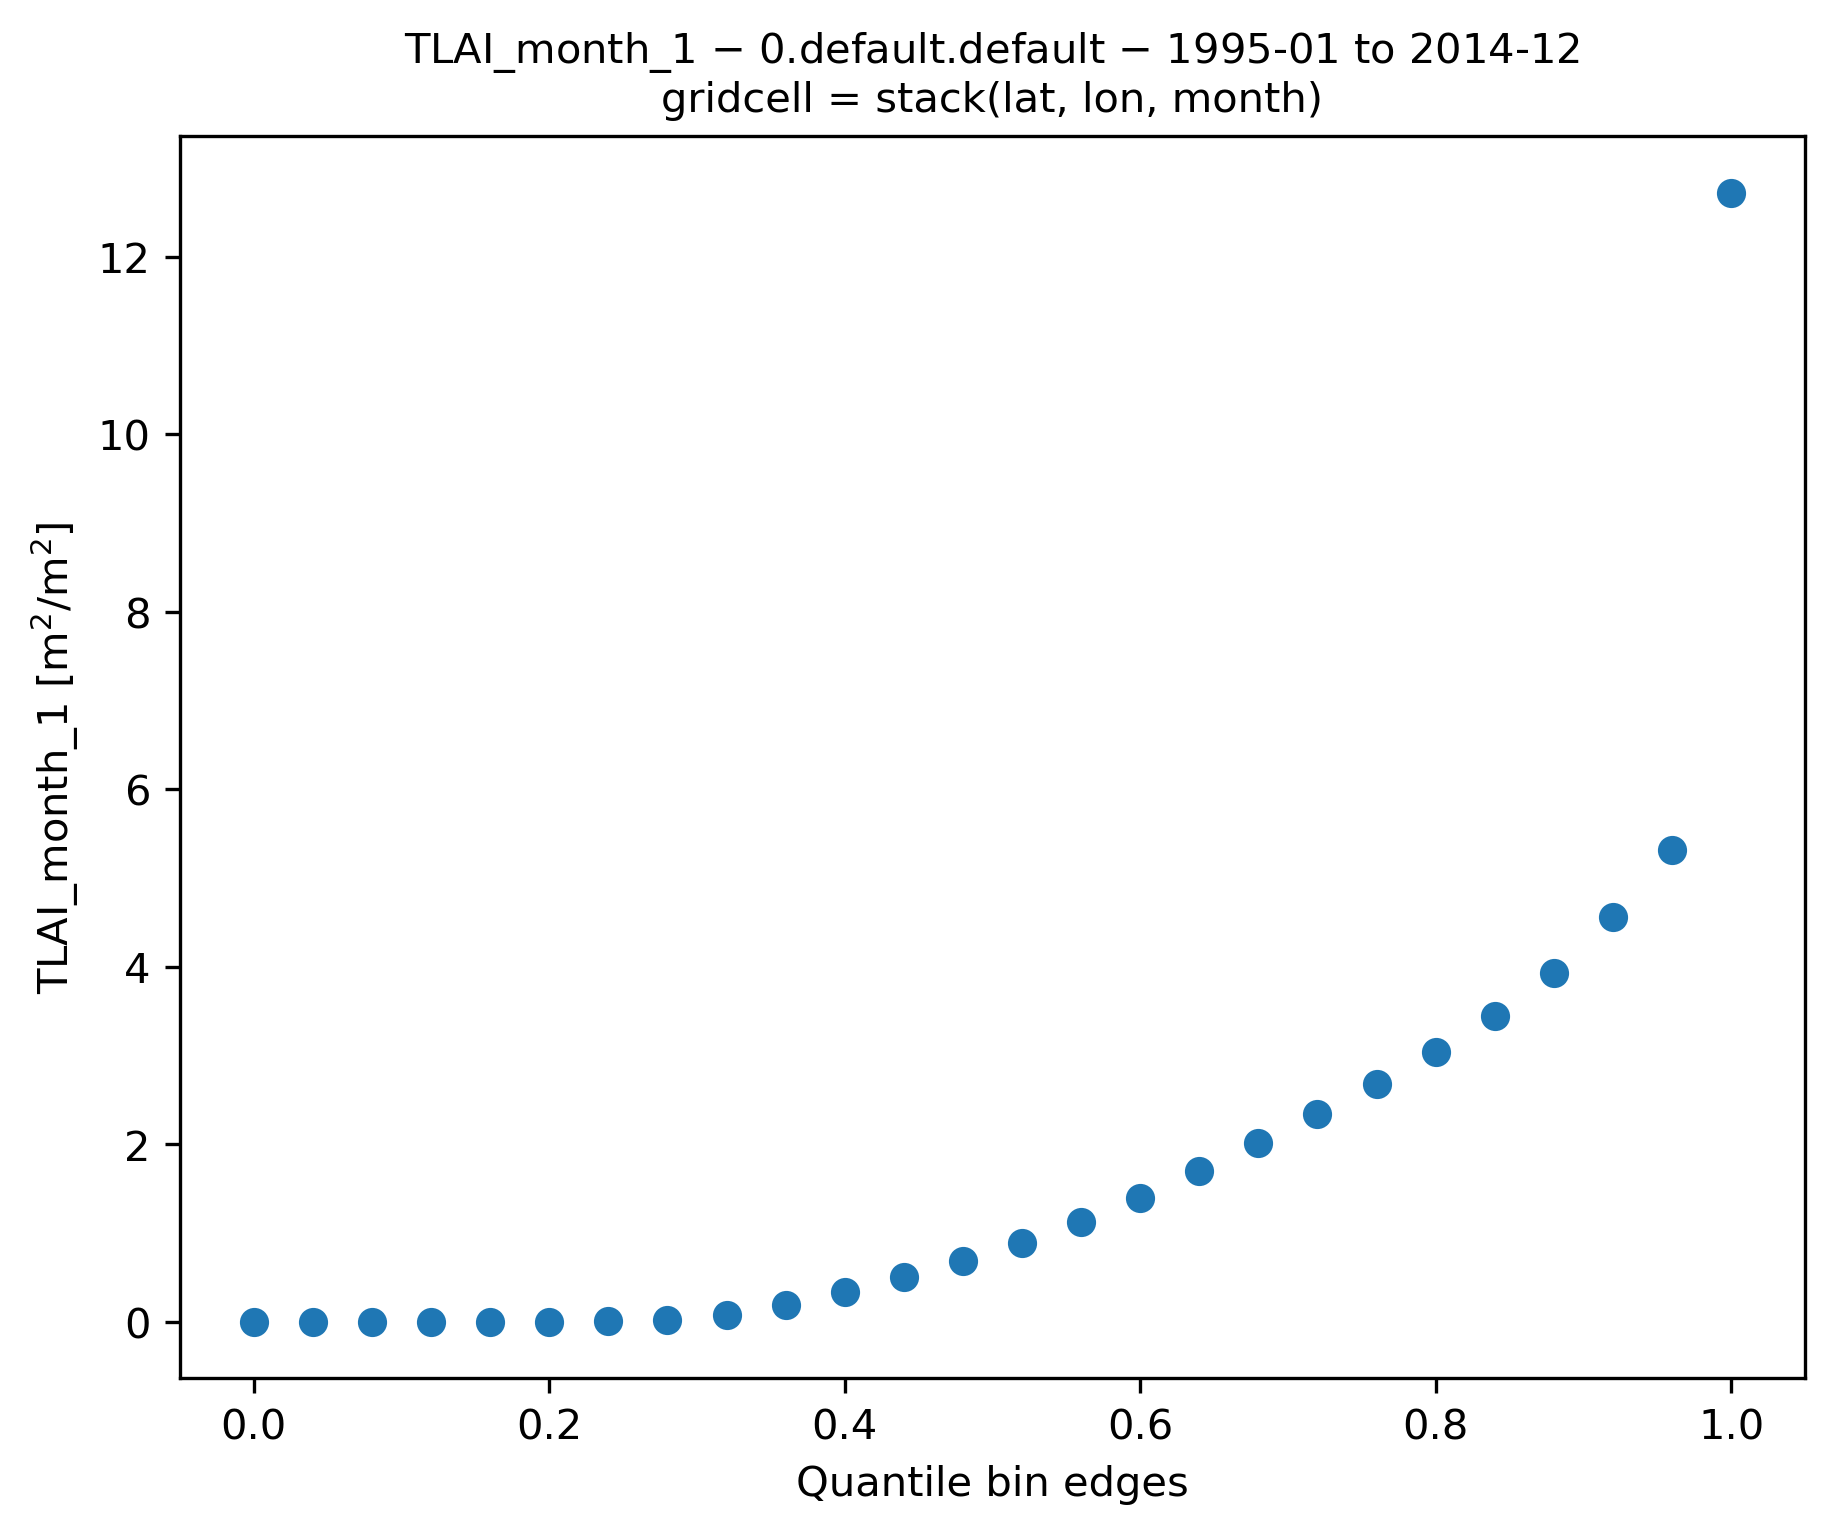

In [34]:
m = 0

fig, ax = plt.subplots(1, 1, figsize=(6, 5), layout="constrained", dpi=300)
x_qedge.sel(member=m).plot(ax=ax, marker="o", lw=0)
ax.set_ylabel(f"{v} [{units}]")
ax.set_xlabel("Quantile bin edges")
ax.set_title(f"{v} $-$ {xclim.ppe.get_member_name(m)} $-$ {time_start} to {time_stop}\ngridcell = stack(lat, lon, month)", fontsize=10)

Text(0.5, 1.0, 'TLAI_month_1 $-$ 23.lmrha.min $-$ 1995-01 to 2014-12\ngridcell = stack(lat, lon, month)')

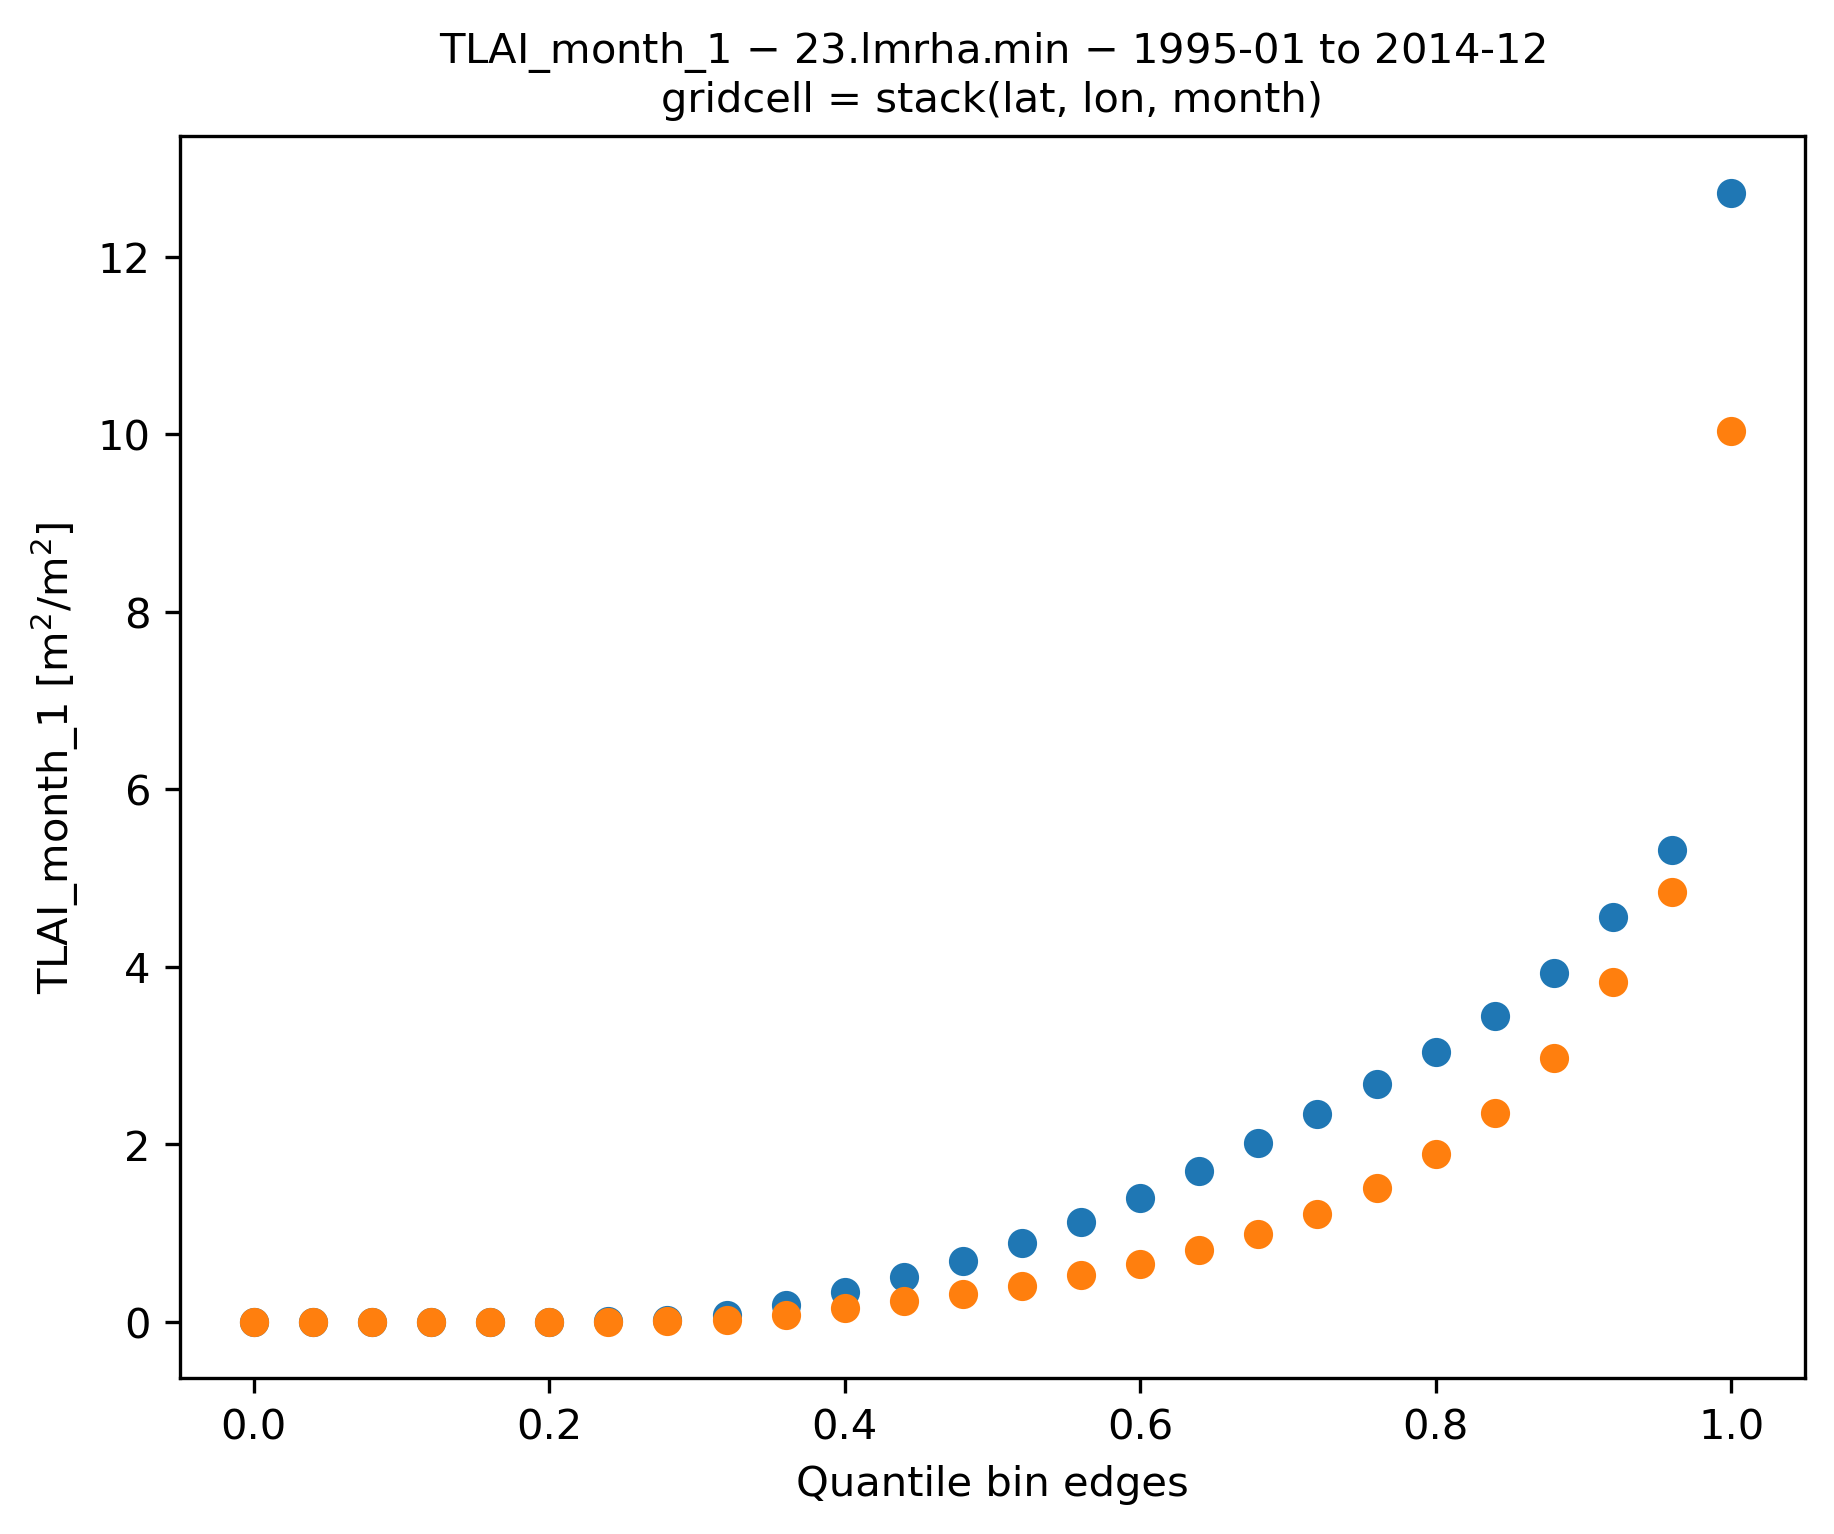

In [38]:
m = 23

fig, ax = plt.subplots(1, 1, figsize=(6, 5), layout="constrained", dpi=300)
ax.plot(x_qedge["quantile"], x_qedge.sel(member=0), marker="o", lw=0, label="Default")
ax.plot(x_qedge["quantile"], x_qedge.sel(member=m), marker="o", lw=0, label="Perturbed")
ax.set_ylabel(f"{v} [{units}]")
ax.set_xlabel("Quantile bin edges")
ax.set_title(f"{v} $-$ {xclim.ppe.get_member_name(m)} $-$ {time_start} to {time_stop}\ngridcell = stack(lat, lon, month)", fontsize=10)

Text(0.5, 1.0, 'TLAI_month_1 $-$ 23.lmrha.min $-$ 1995-01 to 2014-12\ngridcell = stack(lat, lon, month)')

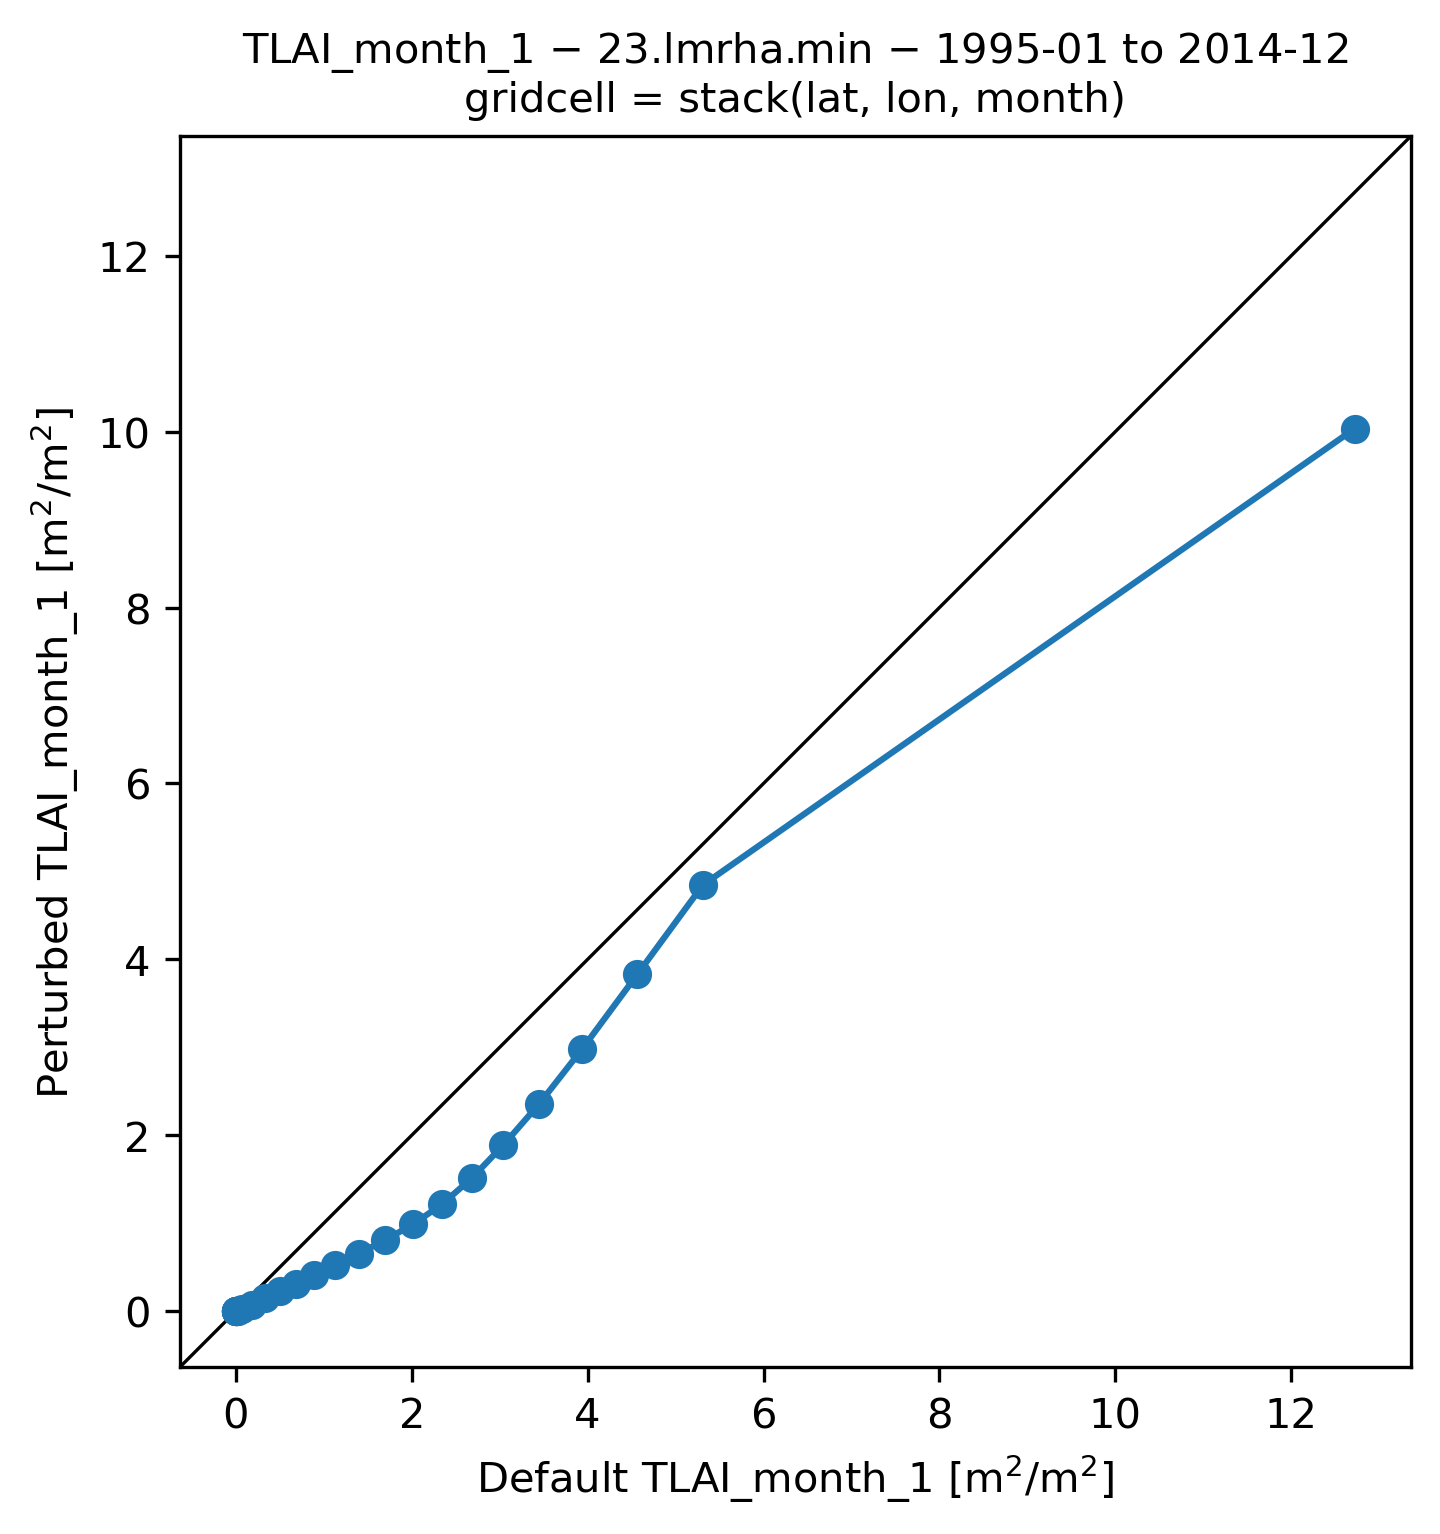

In [36]:
m = 23

fig, ax = plt.subplots(1, 1, figsize=(6, 5), layout="constrained", dpi=300)
ax.set_aspect("equal")
ax.plot(
    x_qedge.sel(member=0),
    x_qedge.sel(member=m),
    color="tab:blue",
    marker="o",
)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
low = min([xlim[0], ylim[0]])
hgh = max([xlim[1], ylim[1]])
ax.plot([low, hgh], [low, hgh], color="k", lw=0.8, zorder=0)
ax.set_xlim(low, hgh)
ax.set_ylim(low, hgh)
ax.set_ylabel(f"Perturbed {v} [{units}]")
ax.set_xlabel(f"Default {v} [{units}]")
ax.set_title(f"{v} $-$ {xclim.ppe.get_member_name(m)} $-$ {time_start} to {time_stop}\ngridcell = stack(lat, lon, month)", fontsize=10)